# Multiple Regression

In this notebook you will use data on house sales in [King County from Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction/data) to predict prices using multiple regression. We will:
* Use SFrames to do some feature engineering
* Use built-in turicreate functions to compute the regression weights (coefficients/parameters)
* Given the regression weights, predictors and outcome write a function to compute the Residual Sum of Squares
* Look at coefficients and interpret their meanings
* Evaluate multiple models via RSS

In [37]:
import turicreate as tc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
df_sales = tc.SFrame('../../../data/kc_house_data.gl/')

In [3]:
df_sales.head()

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront
7129300520,2014-10-13 00:00:00+00:00,221900,3.0,1.0,1180.0,5650,1.0,0
6414100192,2014-12-09 00:00:00+00:00,538000,3.0,2.25,2570.0,7242,2.0,0
5631500400,2015-02-25 00:00:00+00:00,180000,2.0,1.0,770.0,10000,1.0,0
2487200875,2014-12-09 00:00:00+00:00,604000,4.0,3.0,1960.0,5000,1.0,0
1954400510,2015-02-18 00:00:00+00:00,510000,3.0,2.0,1680.0,8080,1.0,0
2008000270,2015-01-15 00:00:00+00:00,291850,3.0,1.5,1060.0,9711,1.0,0
2414600126,2015-04-15 00:00:00+00:00,229500,3.0,1.0,1780.0,7470,1.0,0
1736800520,2015-04-03 00:00:00+00:00,662500,3.0,2.5,3560.0,9796,1.0,0
9297300055,2015-01-24 00:00:00+00:00,650000,4.0,3.0,2950.0,5000,2.0,0
6865200140,2014-05-29 00:00:00+00:00,485000,4.0,1.0,1600.0,4300,1.5,0


### Split data into training and testing.
We use seed=0 so that everyone running this notebook gets the same results.  In practice, you may set a random seed (or let GraphLab Create pick a random seed for you).  

In [4]:
train_data,test_data = df_sales.random_split(.8,seed=0)

---
### Learning a multiple regression model

Recall we can use the following code to learn a multiple regression model predicting 'price' based on the following features:
example_features = ['sqft_living', 'bedrooms', 'bathrooms'] on training data with the following code:

(Aside: We set validation_set = None to ensure that the results are always the same)

In [5]:
example_features = ['sqft_living', 'bathrooms']
example_model = tc.linear_regression.create(train_data, target = 'price', features = example_features, validation_set = None)

Linear regression:

--------------------------------------------------------

Number of examples          : 7004

Number of features          : 2

Number of unpacked features : 2

Number of coefficients    : 3

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 1.024373     | 4289301.802969     | 259960.882881 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

In [6]:
#example_weight_summary = example_model.coefficients()
#print (example_weight_summary)

Now that we have fitted the model we can extract the regression weights (coefficients) as an SFrame as follows:

### Predicting Values

In the gradient descent notebook we use numpy to do our regression. In this book we will use existing turicreate functions to analyze multiple regressions. 

Recall that once a model is built we can use the .predict() function to find the predicted values for data we pass. For example using the example model above:

In [20]:
example_predictions = example_model.predict(train_data)

In [22]:
print (example_predictions[0]) # should be 280466.91558480915

280466.91558480915


### Create some new features

Although we often think of multiple regression as including multiple different features (e.g. # of bedrooms, squarefeet, and # of bathrooms) but we can also consider transformations of existing features e.g. the log of the squarefeet or even "interaction" features such as the product of bedrooms and bathrooms.

You will use the logarithm function to create a new feature. so first you should import it from the math library.

In [8]:
from math import log

Next create the following 4 new features as column in both TEST and TRAIN data:
* bedrooms_squared = bedrooms\*bedrooms
* bed_bath_rooms = bedrooms\*bathrooms
* log_sqft_living = log(sqft_living)
As an example here's the first one:

In [11]:
train_data['bedrooms_squared'] = train_data['bedrooms']*train_data['bedrooms']
test_data['bedrooms_squared'] = test_data['bedrooms']*test_data['bedrooms']
train_data['bed_bath_rooms'] = train_data['bedrooms']*train_data['bathrooms']
test_data['bed_bath_rooms'] = test_data['bedrooms']*test_data['bathrooms']
train_data['log_sqft_living'] = np.log(train_data['sqft_living'])
test_data['log_sqft_living'] = np.log(test_data['sqft_living'])

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this feature will mostly affect houses with many bedrooms.
* bedrooms times bathrooms gives what's called an "interaction" feature. It is large when *both* of them are large.
* Taking the log of squarefeet has the effect of bringing large values closer together and spreading out small values.

**Quiz Question: What is the mean (arithmetic average) value of the 4 new features on TEST data? (round to 2 digits)**

In [12]:
print (
test_data['bedrooms_squared'].mean(),
test_data['bed_bath_rooms'].mean(),
test_data['log_sqft_living'].mean()
)

12.111241907004114 7.449970570924071 7.549840551022271


### Learning Multiple Models

Now we will learn the weights for three (nested) models for predicting house prices. The first model will have the fewest features the second model will add one more feature and the third will add a few more:
* Model 1: squarefeet, # bedrooms, # bathrooms, latitude & longitude
* Model 2: add bedrooms\*bathrooms
* Model 3: Add log squarefeet, bedrooms squared, and the (nonsensical) latitude + longitude

In [13]:
model_1_features = ['sqft_living', 'bedrooms', 'bathrooms', 'lat', 'long']
model_2_features = model_1_features + ['bed_bath_rooms']
model_3_features = model_2_features + ['bedrooms_squared', 'log_sqft_living']

Now that you have the features, learn the weights for the three different models for predicting target = 'price' using tc.linear_regression.create() and look at the value of the weights/coefficients:

In [14]:
# Learn the three models: (don't forget to set validation_set = None)
model_1 = tc.linear_regression.create(train_data, target = 'price', features = model_1_features, validation_set = None)
model_2 = tc.linear_regression.create(train_data, target = 'price', features = model_2_features, validation_set = None)
model_3 = tc.linear_regression.create(train_data, target = 'price', features = model_3_features, validation_set = None)

Linear regression:

--------------------------------------------------------

Number of examples          : 7004

Number of features          : 5

Number of unpacked features : 5

Number of coefficients    : 6

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.008275     | 4075169.881979     | 235754.044970 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 7004

Number of features          : 6

Number of unpacked features : 6

Number of coefficients    : 7

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.013357     | 3626934.630368     | 233900.630830 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 7004

Number of features          : 8

Number of unpacked features : 8

Number of coefficients    : 9

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.011476     | 2642107.052746     | 224840.185571 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

In [19]:
# Examine/extract each model's coefficients:
print (model_1.coefficients, model_2.coefficients, model_3.coefficients)

+-------------+-------+---------------------+--------------------+
|     name    | index |        value        |       stderr       |
+-------------+-------+---------------------+--------------------+
| (intercept) |  None | -46272084.605870046 | 2576107.2286141445 |
| sqft_living |  None |  308.3121622049494  | 5.0393505199847075 |
|   bedrooms  |  None |  -47543.86148712829 | 3519.0866913040363 |
|  bathrooms  |  None |  13741.404158497004 | 5660.234601819675  |
|     lat     |  None |   570910.399735758  | 20657.33903342742  |
|     long    |  None | -156673.71774977297 | 20698.37811393488  |
+-------------+-------+---------------------+--------------------+
[6 rows x 4 columns]
 +----------------+-------+---------------------+--------------------+
|      name      | index |        value        |       stderr       |
+----------------+-------+---------------------+--------------------+
|  (intercept)   |  None |  -44590494.73749479 | 2570431.7905104277 |
|  sqft_living   |  None |  

**Quiz Question: What is the sign (positive or negative) for the coefficient/weight for 'bathrooms' in model 1?**

**Quiz Question: What is the sign (positive or negative) for the coefficient/weight for 'bathrooms' in model 2?**

Think about what this means.

### Predicting Values

In [23]:
predictions_1 = model_1.predict(train_data)
predictions_2 = model_2.predict(train_data)
predictions_3 = model_3.predict(train_data)

In [24]:
#Comparing real vs predict

In [29]:
print ('first real value:      {}\nfirst predicted value: {}'.format(train_data['price'][0], predictions_1[0]))

first real value:      221900
first predicted value: 241914.66443987563


In [30]:
#Compute for the model 2 and 3

### Comparing multiple models

Now that you've learned three models and extracted the model weights we want to evaluate which model is best.

In [32]:
#tc.evaluation.rmse(targets, predictions)
rmse_1 = tc.evaluation.rmse(train_data['price'], predictions_1)
rmse_2 = tc.evaluation.rmse(train_data['price'], predictions_2)
rmse_3 = tc.evaluation.rmse(train_data['price'], predictions_3)

In [33]:
print(rmse_1, rmse_2, rmse_3)

235754.04497031617 233900.63083005484 224840.18557146905


In [34]:
#Plot the results

**Quiz Question: Which model (1, 2 or 3) has lowest RSS on TRAINING Data?

In [35]:
#OVERFITTING EXAMPLE

### Overfitting on a Polynomial regression

In [65]:
def poly(x,i): 
    pote = x**i 
    return pote
def polynomial_sframe(feature, degree):
    poly_sframe = tc.SFrame()
    poly_sframe['power_1'] = feature
    if degree > 1:
        for power in range(2, degree+1): 
            name = 'power_' + str(power)
            poly_sframe[name] = poly(feature,power)
    return poly_sframe

In [66]:
df_sales = df_sales.sort(['sqft_living','price'])

Let us revisit the 15th-order polynomial model using the 'sqft_living' input. Generate polynomial features up to degree 15 using `polynomial_sframe()` and fit a model with these features. When fitting the model, use an L2 penalty of `1e-5`:

In [60]:
l2_small_penalty = 1e-5

Note: When we have so many features and so few data points, the solution can become highly numerically unstable, which can sometimes lead to strange unpredictable results.  Thus, rather than using no regularization, we will introduce a tiny amount of regularization (`l2_penalty=1e-5`) to make the solution numerically stable.  (In lecture, we discussed the fact that regularization can also help with numerical stability, and here we are seeing a practical example.)

With the L2 penalty specified above, fit the model and print out the learned weights.

Hint: make sure to add 'price' column to the new SFrame before calling `graphlab.linear_regression.create()`. Also, make sure GraphLab Create doesn't create its own validation set by using the option `validation_set=None` in this call.

In [67]:
poly1_data = polynomial_sframe(df_sales['sqft_living'], 15)
poly1_data['price'] = df_sales['price'] # add price to the data since it's the target

In [68]:
model1 = tc.linear_regression.create(poly1_data, target = 'price', l2_penalty = l2_small_penalty, validation_set = None)

Linear regression:

--------------------------------------------------------

Number of examples          : 8703

Number of features          : 15

Number of unpacked features : 15

Number of coefficients    : 16

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.011079     | 2273039.967558     | 243419.590601 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

What's the learned value for the coefficient of feature `power_1`?***

In [69]:
model1.coefficients

name,index,value,stderr
(intercept),None,209742.74194351572,nan
power_1,None,-66.6792808283703,nan
power_2,None,0.3528466419410312,nan
power_3,None,-0.0002532436193140599,nan
power_4,None,8.466051612486177e-08,nan
power_5,None,-1.1102740554551446e-11,nan
power_6,None,1.3661372592032503e-16,nan
power_7,None,5.508623957366452e-20,nan
power_8,None,1.1460766937463302e-24,nan
power_9,None,-1.8811355458859035e-28,nan


First, split the data into split the sales data into four subsets of roughly equal size and call them `set_1`, `set_2`, `set_3`, and `set_4`. Use `.random_split` function and make sure you set `seed=0`. 

Hint: When calling `graphlab.linear_regression.create()`, use the same L2 penalty as before (i.e. `l2_small_penalty`).  Also, make sure GraphLab Create doesn't create its own validation set by using the option `validation_set = None` in this call.

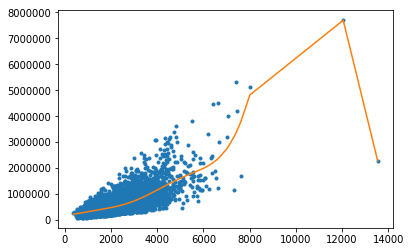

In [71]:
plt.plot(poly1_data['power_1'], poly1_data['price'],'.',)
plt.plot(poly1_data['power_1'], model1.predict(poly1_data))

### Ridge Regression

In [ ]:
model_1_1 = graphlab.linear_regression.create(poly15_set1, target = 'price', 
                                           l2_penalty = 1e5, validation_set = None)

### Lasso Regression

In [5]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in GraphLab Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [6]:
model_all = graphlab.linear_regression.create(sales, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=1e10)

PROGRESS: Linear regression:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 21613
PROGRESS: Number of features          : 17
PROGRESS: Number of unpacked features : 17
PROGRESS: Number of coefficients    : 18
PROGRESS: Starting Accelerated Gradient (FISTA)
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+-----------+--------------+--------------------+---------------+
PROGRESS: | Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |
PROGRESS: +-----------+----------+-----------+--------------+--------------------+---------------+
PROGRESS: Tuning step size. First iteration could take longer than subsequent iterations.
PROGRESS: | 1         | 2        | 0.000002  | 2.135636     | 6962915.603493     | 426631.749026 |
PROGRESS: | 2         | 3        | 0.000002  | 2.309358     | 6843144.200219     | 392488.929838 |
PROGRESS: | 3         | 4      

Find what features had non-zero weight.

In [7]:
weight_summary_all = model_all.get("coefficients")
none_zero_all = model_all['coefficients']['value'].nnz()
none_zero_all

6

In [15]:
weight_summary_all.print_rows(18,3)

+------------------+-------+---------------+
|       name       | index |     value     |
+------------------+-------+---------------+
|   (intercept)    |  None |  274873.05595 |
|     bedrooms     |  None |      0.0      |
| bedrooms_square  |  None |      0.0      |
|    bathrooms     |  None | 8468.53108691 |
|   sqft_living    |  None | 24.4207209824 |
| sqft_living_sqrt |  None | 350.060553386 |
|     sqft_lot     |  None |      0.0      |
|  sqft_lot_sqrt   |  None |      0.0      |
|      floors      |  None |      0.0      |
|  floors_square   |  None |      0.0      |
|    waterfront    |  None |      0.0      |
|       view       |  None |      0.0      |
|    condition     |  None |      0.0      |
|      grade       |  None | 842.068034898 |
|    sqft_above    |  None | 20.0247224171 |
|  sqft_basement   |  None |      0.0      |
|     yr_built     |  None |      0.0      |
|   yr_renovated   |  None |      0.0      |
+------------------+-------+---------------+
[18 rows x

Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

(intercept), bathrooms, sqft_living, sqft_living_sqrt MAL
hay que sacar todos los no ceros
grade, sqft_living

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [8]:
(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [14]:
#l1_range = np.logspace(8, 10, num=20)
l1_range = np.logspace(1, 7, num=13)
i = 0
for l1_pa in l1_range:
    model2 = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=l1_pa,verbose = False)
    none_zero = model2['coefficients']['value'].nnz()
    i = i+1
    print 'i = ',i, 'L1P = ', l1_pa, 'None Zero Value = ',none_zero 

i =  1 L1P =  10.0 None Zero Value =  18
i =  2 L1P =  31.6227766017 None Zero Value =  18
i =  3 L1P =  100.0 None Zero Value =  18
i =  4 L1P =  316.227766017 None Zero Value =  18
i =  5 L1P =  1000.0 None Zero Value =  18
i =  6 L1P =  3162.27766017 None Zero Value =  18
i =  7 L1P =  10000.0 None Zero Value =  18
i =  8 L1P =  31622.7766017 None Zero Value =  18
i =  9 L1P =  100000.0 None Zero Value =  18
i =  10 L1P =  316227.766017 None Zero Value =  18
i =  11 L1P =  1000000.0 None Zero Value =  18
i =  12 L1P =  3162277.66017 None Zero Value =  18
i =  13 L1P =  10000000.0 None Zero Value =  18


*** QUIZ QUESTIONS ***
1. What was the best value for the `l1_penalty`?
2. What is the RSS on TEST data of the model with the best `l1_penalty`?